In [1]:
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
import azureml.dataprep as dprep
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.train.automl import AutoMLConfig
from azureml.core.dataset import Dataset

import warnings
warnings.filterwarnings('ignore')

In [2]:
#check the version of azureml.core
print("the version of azureml is ", azureml.core.VERSION)

the version of azureml is  1.6.0


In [3]:
ws = Workspace.from_config()

#your experiment_name
experiment_name = 'test'
experiment = Experiment(ws,experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,de1faa6a-bb72-4633-8d66-b148cb10deb9
Workspace Name,Fortuna
Resource Group,Main
Location,westcentralus
Experiment Name,test


In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

#name of the cluster 
cluster_name = 'FortunaCom'

try:
    compute_target = ComputeTarget(workspace=ws,name=cluster_name)
    print("Found Compute, use it!")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',max_nodes=4)
    compute_target =  ComputeTarget.create(ws,cluster_name,compute_config)

compute_target.wait_for_completion(show_output=True)

Found Compute, use it!

Running


In [5]:
import pandas as pd

from azureml.core import Workspace, Dataset

subscription_id = 'de1faa6a-bb72-4633-8d66-b148cb10deb9' # compute id
resource_group = 'Main'
workspace_name = 'Fortuna'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='SDI_new')
df = dataset.to_pandas_dataframe()

In [6]:
# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
         row[column] = float(row[column].strip())
 
# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup
 
# Find the min and max values for each column
def dataset_minmax(dataset):
	minmax = list()
	for i in range(len(dataset[0])):
		col_values = [row[i] for row in dataset]
		value_min = min(col_values)
		value_max = max(col_values)
		minmax.append([value_min, value_max])
	return minmax
 
# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
 
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for _ in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0
 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores


In [7]:
from random import seed
from random import randrange
from csv import reader
from math import sqrt
seed(1)

# for i in len(df.columns()-1):
#     str_column_to_float(df, i)
# # convert class column to integers
# str_column_to_int(df, len(df[0])-1)

In [8]:
# from sklearn.cluster import KMeans
# X = df.values
# kmeans = KMeans(n_clusters=5,max_iter=2000)
# kmeans.fit(X)

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

      
X = df[[# numerical vars  
       'net_asset','growth_rate_net_asset',\
       'intan','ntrsmmda','eqsur','depi','bkprem','rslnltot','intangw','RBCT1J',\
       'lnrs3t12','eqtot','eqconsub','lnatres','eq','numemp','dep','eeffr']].values
# categorical vars
#           ','county','offdom','fdicdbs','stalp','bkclass','otsregnm','tract',\
#        'regagnt','trpower','trexer','trust','stmult','subchaps','offoa','offfor','mutual']].values

wcss = []

for i in range (1,16): #15 cluster
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state=0) 
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


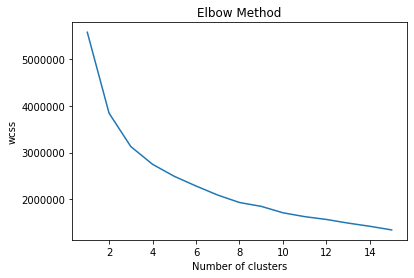

In [10]:
plt.plot(range(1,16),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

AttributeError: 'KMeans' object has no attribute 'cluster_centers'

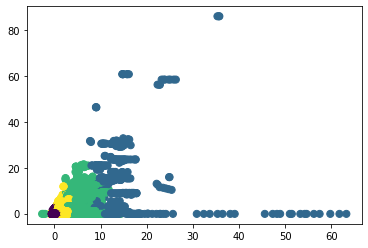

In [11]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# net asset vs goodwill
plt.scatter(X[:, 0], X[:, 8], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('K means clustering result')
plt.xlabel('Net asset')
plt.ylabel('Goodwill')

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# net asset growth vs goodwill
plt.scatter(X[:, 1], X[:, 8], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('K means clustering result')
plt.xlabel('Net asset growth')
plt.ylabel('Goodwill')

In [ ]:
# Randomly select the first cluster center from the data points and append it to the centroid matrix.
i=rd.randint(0,X.shape[0])
Centroid=np.array([X[i]])

# For each data point calculate the euclidian distance square from already chosen centroids and 
# append the minimum distance to a Distance array.
D=np.array([]) 
for x in X:
    D=np.append(D,np.min(np.sum((x-Centroid)**2)))

# Calculate the probabilities of choosing the particular data point as the next centroid by dividing 
# the Distance array elements with the sum of Distance array
prob=D/np.sum(D)

#  Calculate the cumulative probability distribution from this PD distribution
cummulative_prob=np.cumsum(prob)

# Select a random number between 0 to 1, get the index (i) of the cumulative probability distribution which 
# is just greater than the chosen random number and assign the data point corresponding to the selected index (i).
r=rd.random()
i=0
for j,p in enumerate(cummulative_prob):
    if r<p:
       i=j
       break
Centroid=np.append(Centroid,[X[i]],axis=0)

# Putting together in a for loop for K clusters
i=rd.randint(0,X.shape[0])
Centroid=np.array([X[i]])
K=5
for k in range(1,K):
    D=np.array([]) 
    for x in X:
        D=np.append(D,np.min(np.sum((x-Centroid)**2)))
    prob=D/np.sum(D)
    cummulative_prob=np.cumsum(prob)
    r=rd.random()
    i=0
    for j,p in enumerate(cummulative_prob):
        if r<p:
            i=j
            break
    Centroid=np.append(Centroid,[X[i]],axis=0)
    

In [ ]:
for i in range(K):
    rand=rd.randint(0,m-1)
    Centroids_rand=np.c_[Centroids_rand,X[rand]]
plt.scatter(X[:,0],X[:,1])
plt.scatter(Centroid_temp[:,0],Centroid_temp[:,1],s=200,color='yellow')
plt.scatter(Centroids_rand[0,:],Centroids_rand[1,:],s=300,color='black')

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()